https://blog.fastforwardlabs.com/2018/04/10/pytorch-for-recommenders-101.html

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import utils
from collections import Counter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
rating, user_column_index, item_column_index = utils.get_movielens_data()

(100000, 4)
(1682, 24)
(943, 5)


In [4]:
rating["rating"] = rating["rating"]/5

# rating["rating"] =  MinMaxScaler().fit_transform(rating[["rating"]].values).reshape(-1)

In [5]:
n_users = rating["userid"].max() + 1
n_items = rating["itemid"].max() + 1
print(n_users, n_items)
train_df, test_df = utils.movielens_train_test_split(rating)
train_df.shape, test_df.shape

train_df, val_df = utils.movielens_train_test_split(train_df)
train_df.shape, val_df.shape

944 1683


((98105, 49), (943, 49))

# Create expanded matrix

This section follows the blog
https://techairesearch.com/overview-of-matrix-factorization-techniques-using-python/ 

In [44]:
r = train_df[["userid",  "itemid", "rating"]].pivot(index = "userid", columns = "itemid", values = "rating")
r_columns = r.columns
r_index = r.index.values
r  = r.values
r

array([[1. , 0.6, 0.8, ..., nan, nan, nan],
       [0.8, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [1. , nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, 1. , nan, ..., nan, nan, nan]])

In [45]:
mean_user_ratings = np.nanmean(r, axis = 1)

(array([  1.,   4.,   8.,  33., 112., 232., 301., 179.,  62.,  11.]),
 array([0.29838337, 0.36568789, 0.43299241, 0.50029693, 0.56760145,
        0.63490597, 0.70221049, 0.76951501, 0.83681953, 0.90412405,
        0.97142857]),
 <BarContainer object of 10 artists>)

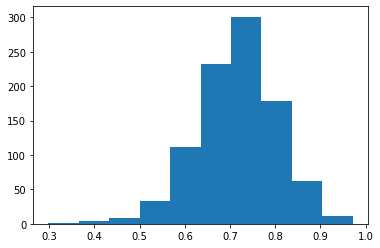

In [46]:
plt.hist(mean_user_ratings)

### Normalize the ratings by user

In [47]:
r = r - mean_user_ratings.reshape(-1,1)

# SVD
https://beckernick.github.io/matrix-factorization-recommender/

In [48]:
from scipy.sparse.linalg import svds

In [49]:
U, sigma, Vt = svds(r, k = 50)

/opt/conda/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1886: RuntimeWarning: invalid value encountered in greater
  above_cutoff = (eigvals > cutoff)


In [50]:
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + mean_user_ratings.reshape(-1, 1)

preds = pd.DataFrame(all_user_predicted_ratings, columns = r_columns)

preds["userid"] = r_index

preds = pd.melt(preds, id_vars = "userid", value_vars = r_columns, value_name = "rating")

In [66]:
res = pd.merge(test_df[['userid', 'itemid', 'rating']], preds, on = ['userid', 'itemid'], how = "left")
print("MAE for mode", mean_absolute_error(res["rating_x"].values, res["rating_y"].values))

MAE for mode 0.17189974911612543


# Surprise library

Benchmarks: 
http://surpriselib.com/

In [68]:
# !pip install surprise

In [85]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD, SVDpp, KNNBaseline
from surprise.model_selection import cross_validate

In [72]:
reader = Reader(rating_scale=(0.2, 1))
data = Dataset.load_from_df(train_df[['userid', 'itemid', 'rating']], reader)

In [90]:
for method in [SVDpp, KNNBaseline]:
    svd = method(verbose=False, n_epochs=15)
    # cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    trainset = data.build_full_trainset()
    svd.fit(trainset)

    pred = [
        svd.predict(uid=test_df["userid"].values[i],
                    iid=test_df["itemid"].values[i]).est
        for i in range(len(test_df))
    ]
    print(f"{method.__name__} MAE for mode", mean_absolute_error(test_df["rating"].values, pred))

SVDppMAE for mode 0.15603665950896226
KNNBaselineMAE for mode 0.15498744380122859


# CF-step: incremental learning
https://pypi.org/project/cf-step/

## Microsoft's recommenders library

In [13]:
# !pip install --ignore-installed PyYAML
# !pip install recommenders
# !pip install tf_slim

In [14]:
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.utils.constants import SEED as DEFAULT_SEED

array([[1.960e+02, 2.420e+02, 6.000e-01],
       [1.860e+02, 3.020e+02, 6.000e-01],
       [2.200e+01, 3.770e+02, 2.000e-01],
       ...,
       [8.510e+02, 1.013e+03, 4.000e-01],
       [9.360e+02, 2.510e+02, 8.000e-01],
       [1.300e+02, 8.240e+02, 6.000e-01]])

In [21]:
# Initial parameters
TOP_K = 10
EPOCHS = 50
BATCH_SIZE = 1024
SEED = DEFAULT_SEED

data = NCFDataset(
    train=pd.DataFrame(data=train_df[['userid', 'itemid', 'rating']],
                       columns=["userID", "itemID", "rating"]),
    test=pd.DataFrame(data=test_df[['userid', 'itemid', 'rating']],
                      columns=["userID", "itemID", "rating"]),
    seed=SEED)

/opt/conda/lib/python3.7/site-packages/recommenders/models/ncf/dataset.py:210: UserWarning: n_neg_test is larger than negative items set size! We will set n_neg as the smallest size: 0
  % min_num


In [22]:
model = NCF (
    n_users=n_users, 
    n_items=n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=1,
    seed=SEED
)

# fitting the model
model.fit(data)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/opt/conda/lib/python3.7/site-packages/recommenders/models/ncf/dataset.py:258: UserWarning: n_neg is larger than negative items set size! We will set n_neg as the smallest size: 0
  % min_num


In [27]:
# predict the data in the test set
pred = [model.predict(u, i) for (u, i) in test_df[['userid', 'itemid']].values]

print("MAE", mean_absolute_error(test_df["rating"].values, pred))

KeyError: 220